# Term Deposit Marketing Campaign
The main objective of this project is to enhance the effectiveness of customer outreach. This project will harness the power of call center data to create a resilient machine learning model to accomplish this.
The model aims to optimise the success rate of calls made to customers, resulting in improved outcomes for products that customers might interested in.
A key element the project is ensure the model not only delivers high call success rates, but also provides interpretability. This interpretability empowers executives to make well informed decisions based on the machine learning model from this project.

# Importing Libraries

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from scikitplot.metrics import plot_lift_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

plt.style.use('fivethirtyeight')

# Loading Data

In [17]:
path = '../data/term-deposit-marketing-2020.csv'
df = pd.read_csv(path)

# Exploratory Data Analysis

In [18]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [19]:
'The dataset has {row} rows and {column} columns'.format(row=df.shape[0], column=df.shape[1])

'The dataset has 40000 rows and 14 columns'

In [20]:
df.isnull().any()


age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
y            False
dtype: bool

In [21]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'y'],
      dtype='object')

In [22]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
y            object
dtype: object

"Yes" and "No" in the target variable was changed to 0 for "No" and 1 for "Yes". This is to make modeling easier. One hot encoding will be used on the categorical and binary variables during preprocessing.

In [23]:
df.nunique()

age            70
job            12
marital         3
education       4
default         2
balance      6849
housing         2
loan            2
contact         3
day            31
month          11
duration     1535
campaign       48
y               2
dtype: int64

There appears to be high rejection rates for a term deposits. Knowing why this is so could be valuable in knowing which people would be more likely to open a term deposit.

In [24]:
df['y'] = df['y'].map({'no': 0, 'yes': 1})


In [25]:
df.dtypes


age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
y             int64
dtype: object

In [26]:
yes = df.loc[df['y'] == 1, 'y']
no = df.loc[df['y'] == 0, 'y']
fraction = len(no)/len(yes)
print('{:.0f}% of the customers opened a opened a term deposit'. format(fraction))

13% of the customers opened a opened a term deposit


C:\Users\Guill\AppData\Local\Temp\ipykernel_72572\3246573383.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='y', data=df, palette='RdBu_r')
C:\Users\Guill\AppData\Local\Temp\ipykernel_72572\3246573383.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No', 'Yes'])


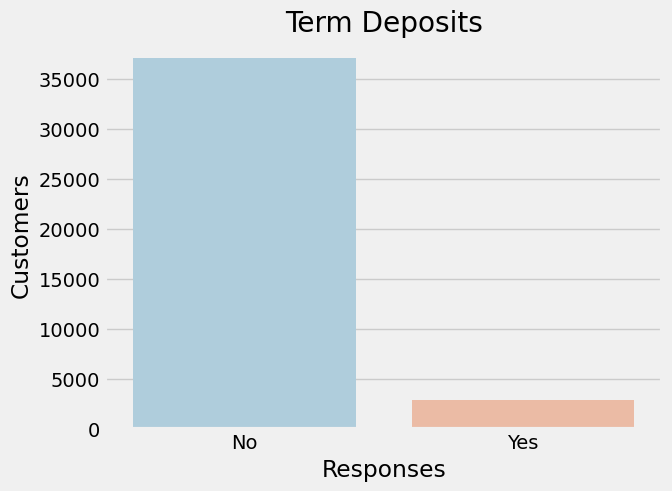

In [27]:
ax = sns.countplot(x='y', data=df, palette='RdBu_r')
ax.set_title('Term Deposits')
plt.ylabel('Customers')
plt.xlabel('Responses')
ax.set_xticklabels(['No', 'Yes'])


plt.show()


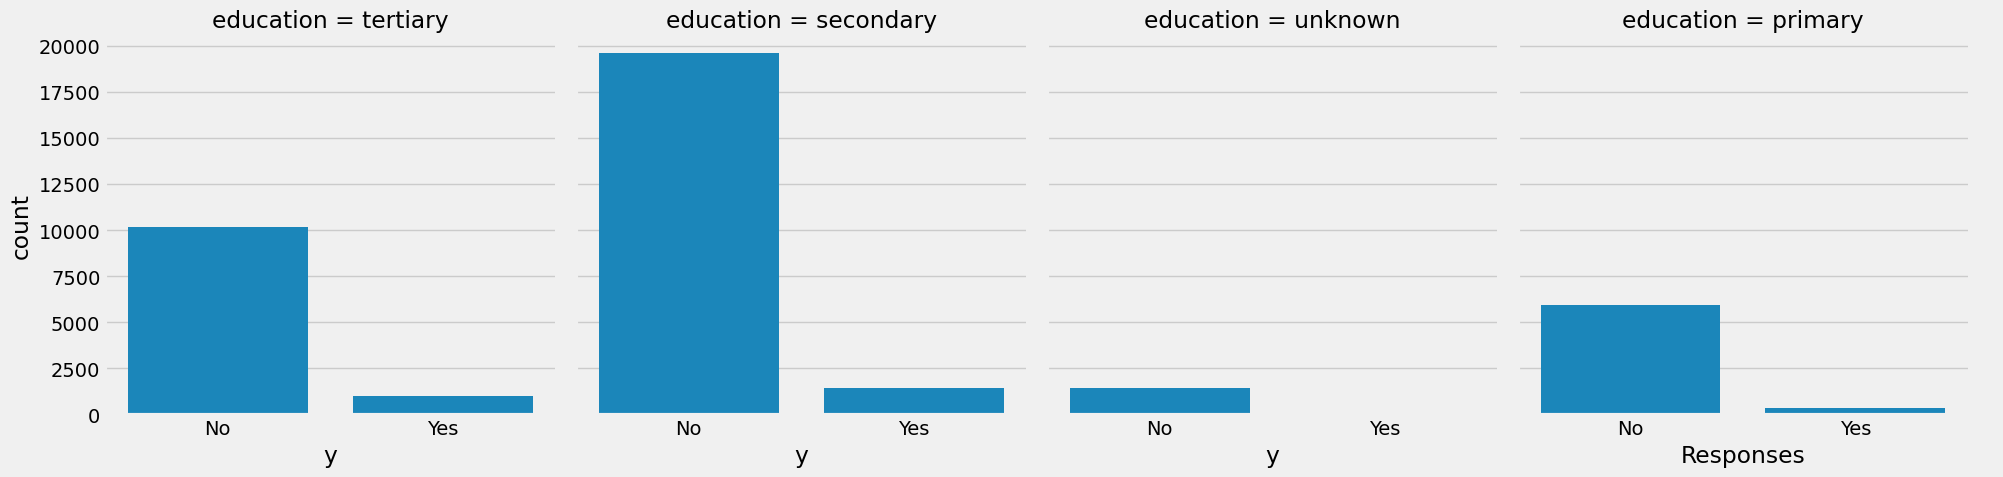

In [28]:
ax = sns.catplot(x='y', col='education', data=df, kind='count')
ax.set_xticklabels(['No', 'Yes'])
plt.xlabel('Responses')
plt.ylabel('Customers')
plt.show()



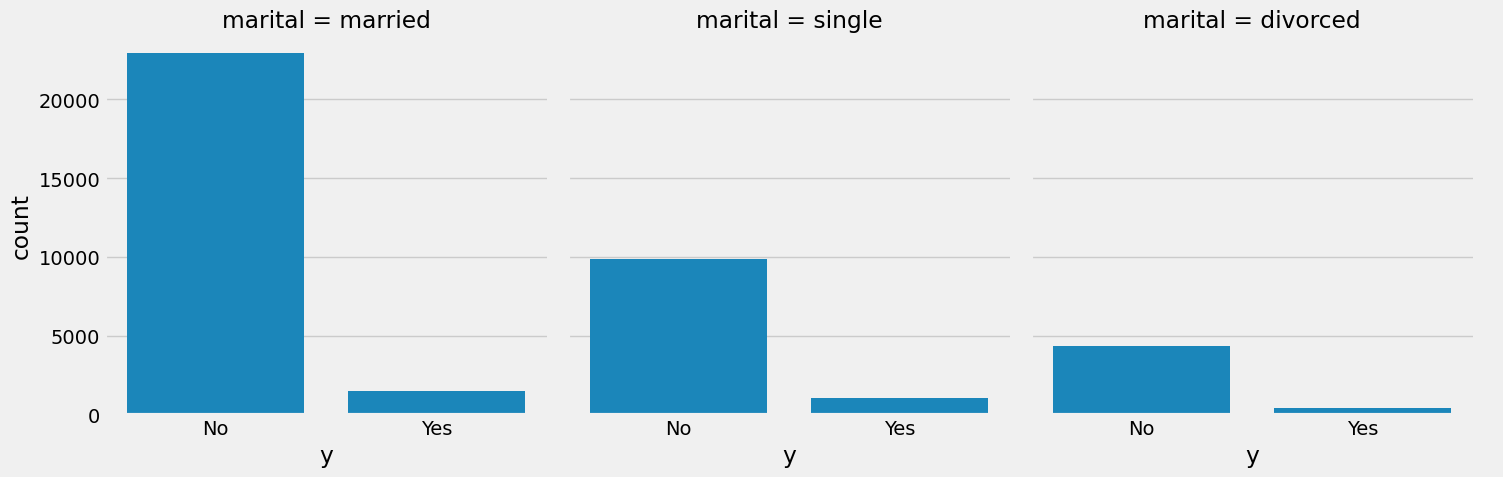

In [29]:
ax = sns.catplot(x='y', col='marital', data=df, kind='count')
ax.set_xticklabels(['No', 'Yes'])
plt.show()


In [30]:
age_yes = df.loc[df['y'] == 1, 'age']
age_no = df.loc[df['y'] == 0, 'age']

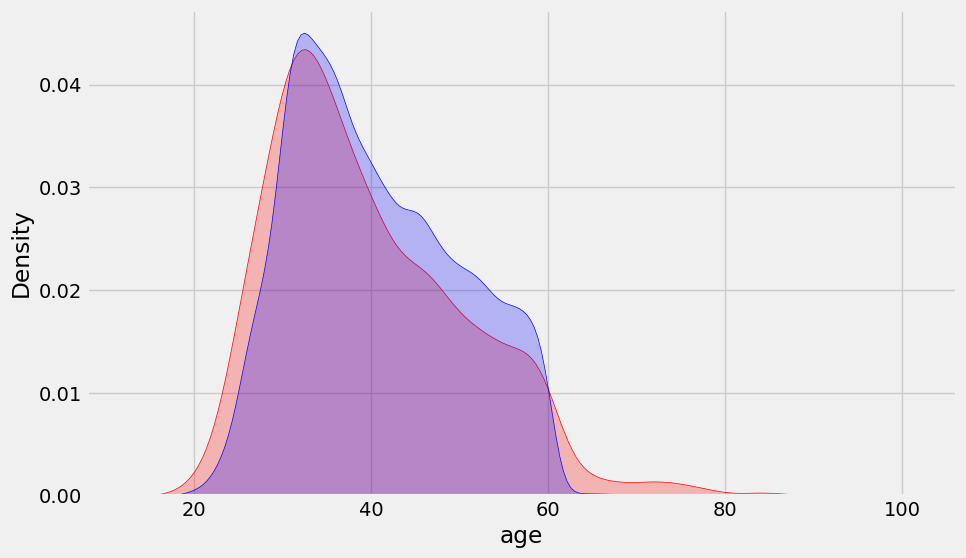

In [31]:
plt.figure(figsize=(10, 6))
ax = sns.kdeplot(age_yes, fill=True, color='red')
ax = sns.kdeplot(age_no, fill=True, color='blue')
plt.show()

C:\Users\Guill\AppData\Local\Temp\ipykernel_72572\1181605176.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['no', 'yes'])


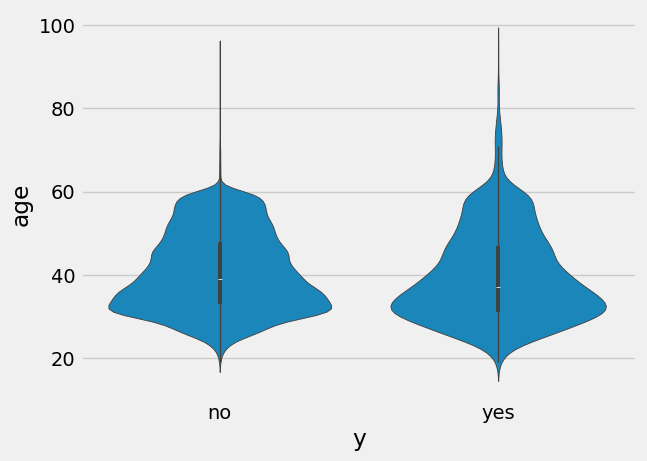

In [32]:
ax = sns.violinplot(x='y', y='age', data=df)
ax.set_xticklabels(['no', 'yes'])
plt.show()



C:\Users\Guill\AppData\Local\Temp\ipykernel_72572\1504593251.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['no', 'yes'])


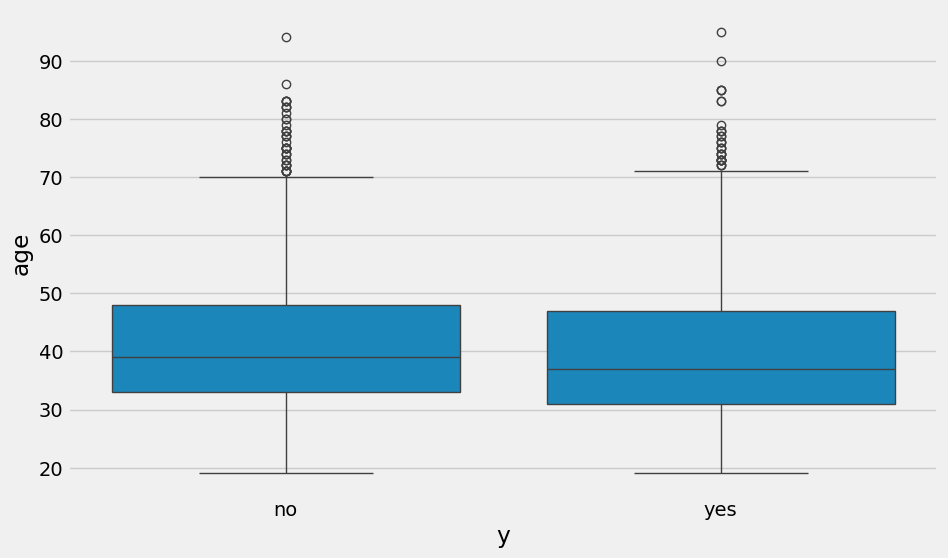

In [33]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='y', y='age', data=df)
ax.set_xticklabels(['no', 'yes'])
plt.show()




# Preprocessing

The features 'day', 'month' and 'duration' were removed from the data before modeling because it was impossible to know the day, month or length of the phone call to a potential customer until it was made in the future.

In [34]:
df.drop(columns=['day', 'month', 'duration', 'age'], inplace=True)

In [35]:
df.head()

,job,marital,education,default,balance,housing,loan,contact,campaign,y
0,management,married,tertiary,no,2143,yes,no,unknown,1,0
1,technician,single,secondary,no,29,yes,no,unknown,1,0
2,entrepreneur,married,secondary,no,2,yes,yes,unknown,1,0
3,blue-collar,married,unknown,no,1506,yes,no,unknown,1,0
4,unknown,single,unknown,no,1,no,no,unknown,1,0


In [36]:
df = pd.get_dummies(df, columns=['job', 'marital', 'education','default', 'housing', 'loan', 'contact'])

In [37]:
df.head()

,balance,campaign,y,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown
0,2143,1,0,False,False,False,False,True,False,False,...,False,True,False,False,True,True,False,False,False,True
1,29,1,0,False,False,False,False,False,False,False,...,False,True,False,False,True,True,False,False,False,True
2,2,1,0,False,False,True,False,False,False,False,...,False,True,False,False,True,False,True,False,False,True
3,1506,1,0,False,True,False,False,False,False,False,...,True,True,False,False,True,True,False,False,False,True
4,1,1,0,False,False,False,False,False,False,False,...,True,True,False,True,False,True,False,False,False,True


In [38]:
X = df.drop(columns=['y'])
y = df['y']


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)


In [41]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(30000, 30)
(10000, 30)
(30000,)
(10000,)


In [42]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Random Forest Classifier

In [43]:
from sklearn.ensemble import RandomForestClassifier


In [44]:
rf = RandomForestClassifier(n_estimators=100, random_state=5678)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.8996

## Random Forest Cross Validation

In [45]:
rf_score = cross_validate(rf, X_train, y_train, scoring='accuracy', cv=5)
sorted(rf_score.keys())
rf_scores = pd.DataFrame(rf_score)
rf_scores

,fit_time,score_time,test_score
0,1.839672,0.089529,0.900333
1,1.955435,0.083806,0.901833
2,1.825373,0.100612,0.903000
3,1.958054,0.086451,0.895833
4,1.866605,0.086801,0.900000


## Random Forest Feature Importance

In [46]:
rf_feature_imp = pd.DataFrame(sorted(zip(rf.feature_importances_, X.columns)), columns=['Value', 'Feature'])
rf_feature_imp.sort_values(by="Value", ascending=False, inplace=True)
rf_feature_imp

,Value,Feature
29,0.712290,balance
28,0.106410,campaign
27,0.010207,education_secondary
26,0.009670,job_technician
25,0.009330,job_blue-collar
24,0.009269,job_admin
23,0.008924,job_management
22,0.008900,education_tertiary
21,0.007508,job_services
20,0.007488,marital_single


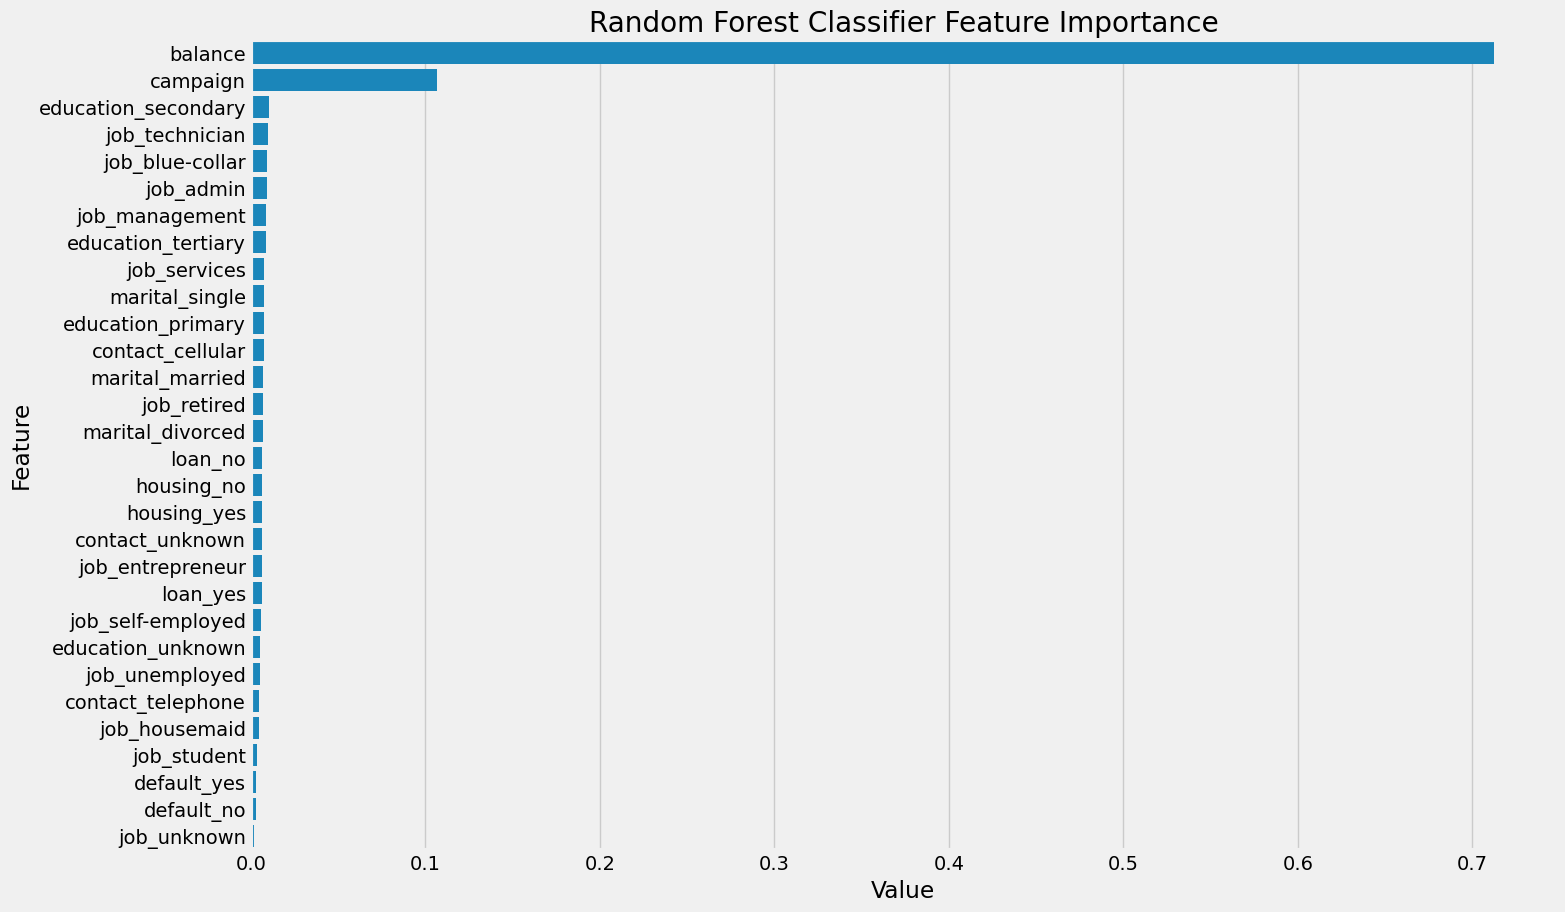

In [47]:
plt.figure(figsize=(15, 10))
sns.barplot(x='Value', y='Feature', data=rf_feature_imp)
plt.title('Random Forest Classifier Feature Importance')
plt.show()

## Random Forest Confusion Matrix

In [48]:
rf_matrix = confusion_matrix(y_test, rf.predict(X_test))

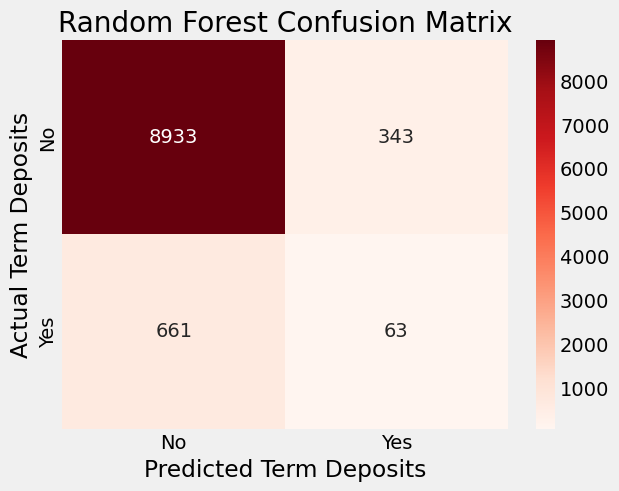

In [49]:
ax = sns.heatmap(rf_matrix, fmt='g', annot=True, cmap="Reds")
plt.title('Random Forest Confusion Matrix')
ax.set_xticklabels(['No', 'Yes'])
ax.set_yticklabels(['No', 'Yes'])
plt.xlabel('Predicted Term Deposits')
plt.ylabel('Actual Term Deposits')
plt.show()

# Lift Analysis
Lift analysis is a technique classification tasks to understand the performance of a model. Since there are high rejection rates for accepting a term deposit, lift analysis could be particularly useful in scenarios where the positive class (the people who are buying term deposits) is relatively rare. It helps us evaluate how much better a model is at targeting the buyers compared to random selection. Since time and funds are a limited resource, randomly contacting potential customers who would open a term deposit would not be optimal.
By employing lift analysis, we can gauge how effectively a model identifies potential buyers compared to a random selection process. This capability is invaluable, especially given the constraints of time and resources. In instances where reaching out to every potential customer for a term deposit is impractical, lift analysis empowers us to focus our efforts where they matter most. By discerning and targeting individuals most likely to open a term deposit, we maximize the utilization of our limited resources, resulting in a more strategic and impactful approach to customer engagement. The ability to optimize our interactions based on a model's performance uplifts the efficiency of decision-making processes and enhances our overall customer outreach strategy.

Below is a function created to plot the lift values for each model used in this project.

In [50]:
def draw_lift_curve(actual_pred, pred, model="Random Forest Classifier"):

  data = np.column_stack((pred, actual_pred))
  data = data[data[:,0].argsort()[::-1]] # sort predicted probalities in
                                         # in descending order

  num_bins = 10 # create ten bins

  bin_size = len(data) // num_bins
  lift_values = []

  for i in range(1, num_bins + 1):
    bin_data = data[:i * bin_size]
    response_rate = np.sum(bin_data[:,1]) / len(bin_data)
    random_response = np.sum(actual_pred) / len(actual_pred)
    lift = response_rate / random_response
    lift_values.append(lift)
  plt.figure(figsize=(10, 6))
  plt.plot(range(1, num_bins + 1), lift_values, marker='o')
  plt.xlabel("Percentage of Customers")
  plt.ylabel("Likelihood of Term Deposit \nCompared to Random Chance")
  plt.xticks(range(1, num_bins + 1), [10 * i for i in range(1, num_bins + 1)])
  plt.title(model + " Lift Analysis")
  return plt.show()



## Random Forest Lift Analysis

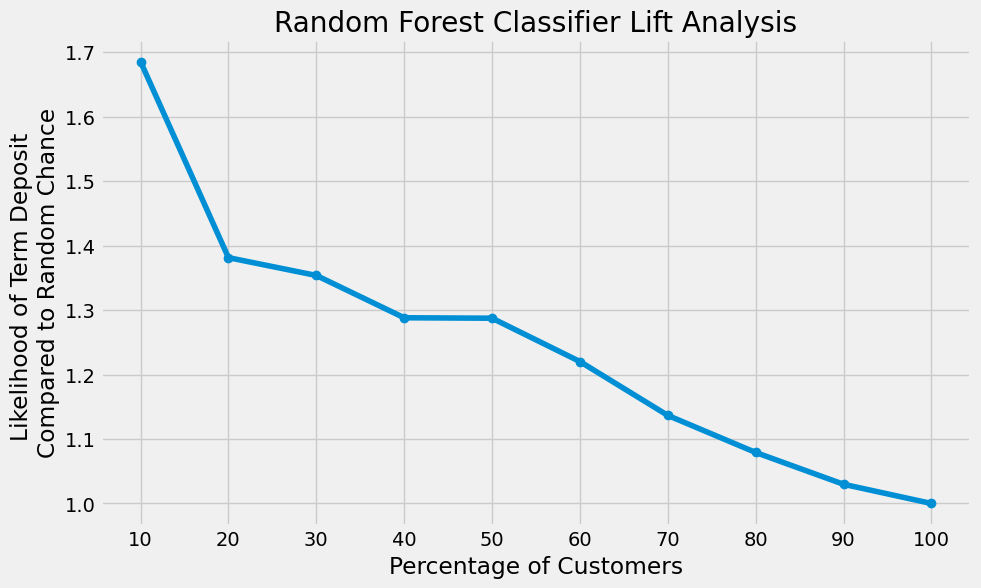

In [51]:
draw_lift_curve(y_test, rf.predict_proba(X_test)[:, 1])

# Extreme Gradient Boosting Classifier

In [52]:
learning_rates = np.arange(0.1, 1.1, 0.1)
for learning_rate in learning_rates:
    xgb = XGBClassifier(n_estimators=100, eta = learning_rate, random_state = 0)
    xgb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(xgb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(xgb.score(X_test, y_test)))
    print()

Learning rate:  0.1
Accuracy score (training): 0.928
Accuracy score (validation): 0.927

Learning rate:  0.2
Accuracy score (training): 0.929
Accuracy score (validation): 0.927

Learning rate:  0.30000000000000004
Accuracy score (training): 0.930
Accuracy score (validation): 0.927

Learning rate:  0.4
Accuracy score (training): 0.932
Accuracy score (validation): 0.926

Learning rate:  0.5
Accuracy score (training): 0.934
Accuracy score (validation): 0.925

Learning rate:  0.6
Accuracy score (training): 0.936
Accuracy score (validation): 0.924

Learning rate:  0.7000000000000001
Accuracy score (training): 0.939
Accuracy score (validation): 0.922

Learning rate:  0.8
Accuracy score (training): 0.941
Accuracy score (validation): 0.921

Learning rate:  0.9
Accuracy score (training): 0.941
Accuracy score (validation): 0.922

Learning rate:  1.0
Accuracy score (training): 0.946
Accuracy score (validation): 0.917



In [53]:
xgb = XGBClassifier(n_estimators=100, eta = .1, random_state = 0)
xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)



0.9275

## Extreme Gradient Boosting Cross Validation

In [54]:
xgb_score = cross_validate(xgb, X_train, y_train, scoring='accuracy', cv=5)



In [55]:
sorted(xgb_score.keys())
xgb_scores = pd.DataFrame(xgb_score)
xgb_scores

,fit_time,score_time,test_score
0,0.153507,0.005998,0.927500
1,0.130746,0.006511,0.927667
2,0.132436,0.005004,0.927667
3,0.136538,0.005001,0.927333
4,0.171467,0.007214,0.927500


## Extreme Gradient Boosting Confusion Matrix

In [56]:
xgb_matrix = confusion_matrix(y_test, xgb.predict(X_test))

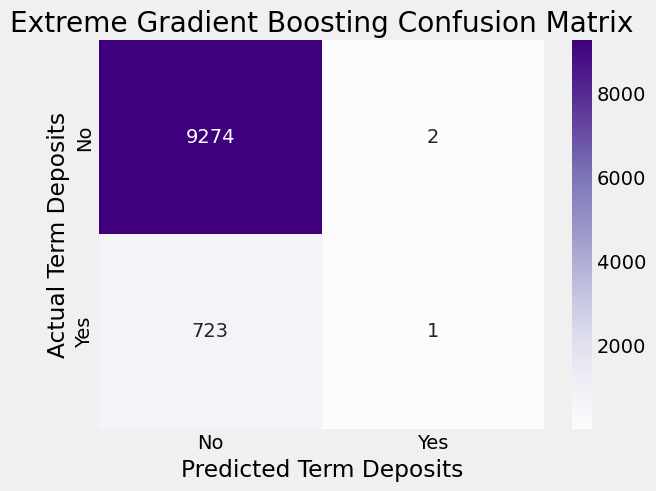

In [57]:
ax = sns.heatmap(xgb_matrix, fmt='g', annot=True, cmap="Purples")
plt.title('Extreme Gradient Boosting Confusion Matrix')
ax.set_xticklabels(['No', 'Yes'])
ax.set_yticklabels(['No', 'Yes'])
plt.xlabel('Predicted Term Deposits')
plt.ylabel('Actual Term Deposits')
plt.show()

## Feature Importance for Extreme Gradient Boosting Classifier

In [60]:
xgb_feature_imp = pd.DataFrame(sorted(zip(xgb.feature_importances_, X.columns)), columns=['Value', 'Feature'])
xgb_feature_imp.sort_values(by="Value", ascending=False, inplace=True)
print(xgb_feature_imp.head(7).to_markdown())


|    |     Value | Feature          |
|---:|----------:|:-----------------|
| 29 | 0.23636   | contact_unknown  |
| 28 | 0.0807953 | contact_cellular |
| 27 | 0.0530467 | marital_married  |
| 26 | 0.0460856 | job_retired      |
| 25 | 0.0419842 | housing_no       |
| 24 | 0.0419526 | job_student      |
| 23 | 0.04      | loan_no          |


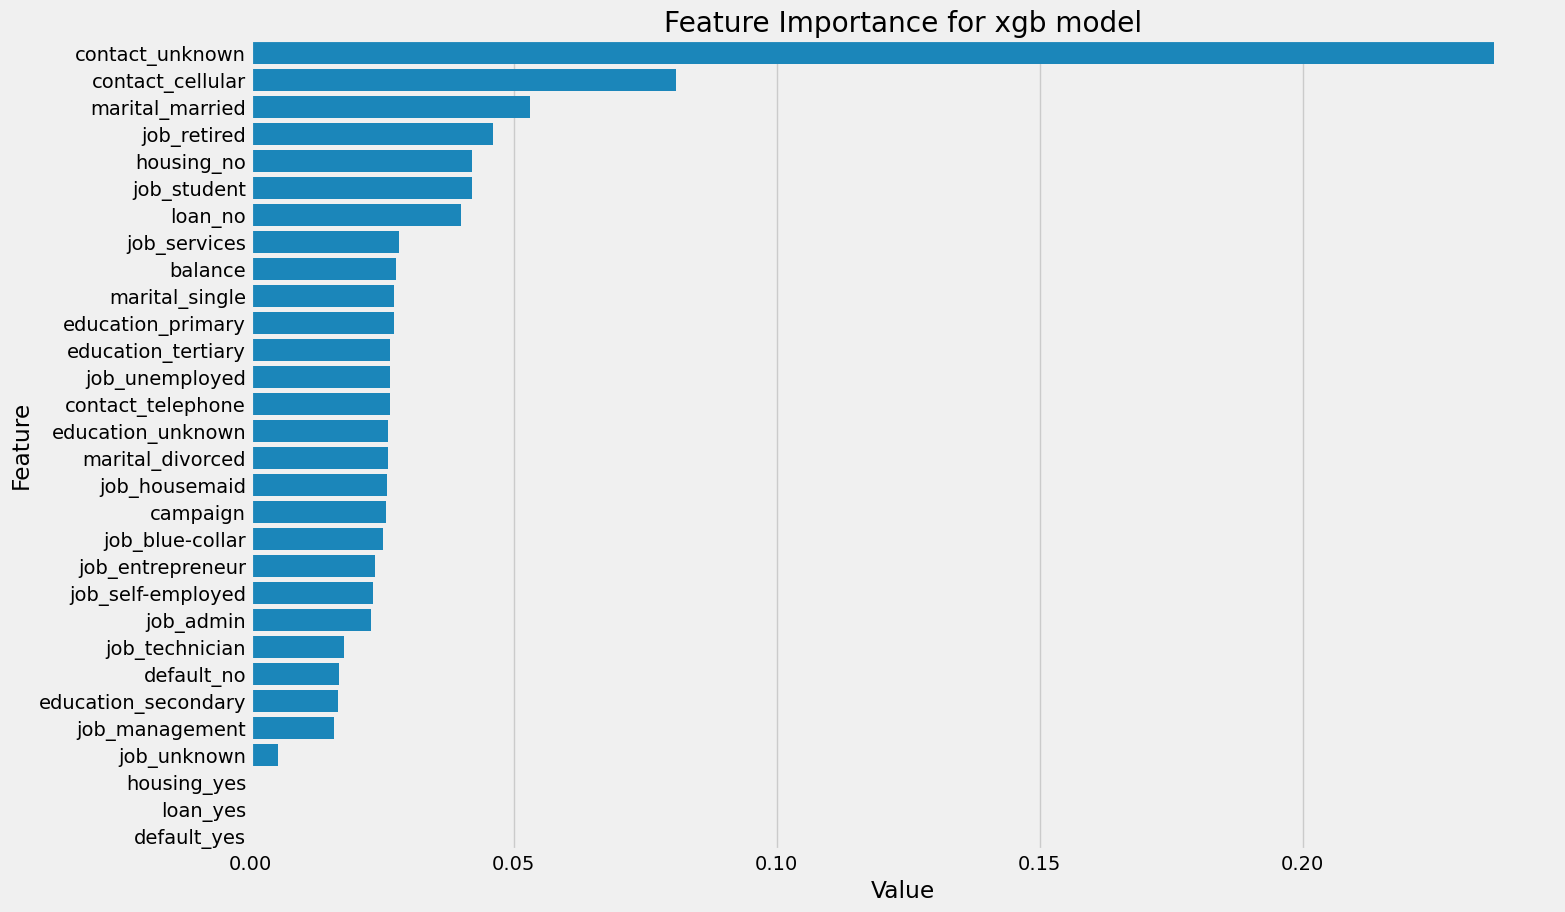

In [61]:
plt.figure(figsize=(15, 10))
sns.barplot(x='Value', y='Feature', data=xgb_feature_imp)
plt.title('Feature Importance for xgb model')
plt.show()

## Lift Analysis Extreme Gradient Boosting Classfier

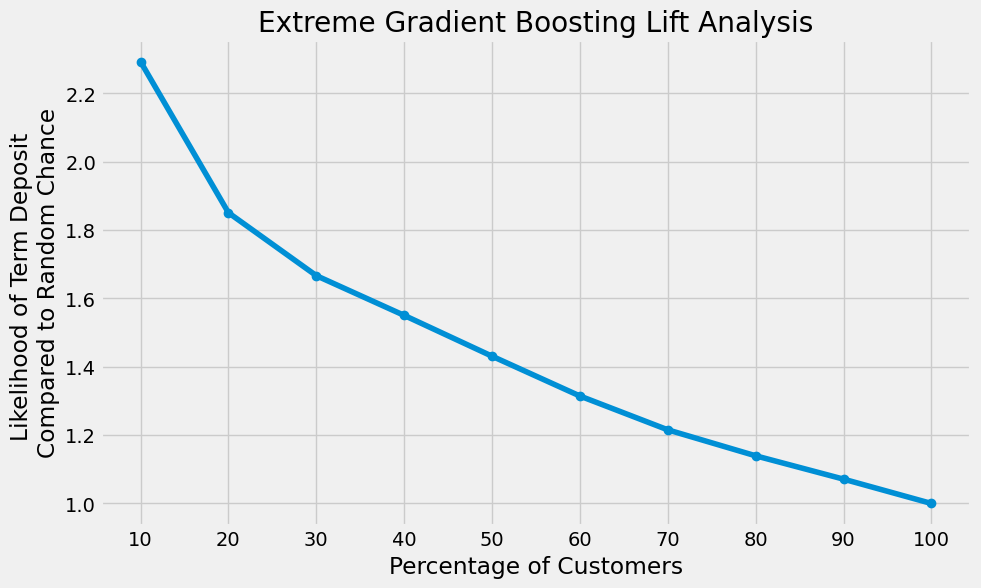

In [62]:
draw_lift_curve(y_test, xgb.predict_proba(X_test)[:,1], model="Extreme Gradient Boosting")

# Light Gradient Boosting Classifier

In [63]:
from lightgbm import LGBMClassifier


In [64]:
verbosity_lvl = 0
learning_rates = np.arange(0.1, 1.1, 0.1)
for learning_rate in learning_rates:
    lgb = LGBMClassifier(n_estimators=100, learning_rate=learning_rate, verbosity = verbosity_lvl, random_state = 0)
    lgb.fit(X_train, y_train)
    print(learning_rate)
    print("Accuracy score (training): {0:.3f}".format(lgb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(lgb.score(X_test, y_test)))
    print()


c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Guill\miniconda3\envs\happy-ml\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


0.1
Accuracy score (training): 0.928
Accuracy score (validation): 0.927

0.2
Accuracy score (training): 0.930
Accuracy score (validation): 0.927

0.30000000000000004
Accuracy score (training): 0.933
Accuracy score (validation): 0.926

0.4
Accuracy score (training): 0.935
Accuracy score (validation): 0.925

0.5
Accuracy score (training): 0.938
Accuracy score (validation): 0.923

0.6
Accuracy score (training): 0.943
Accuracy score (validation): 0.919

0.7000000000000001
Accuracy score (training): 0.944
Accuracy score (validation): 0.917

0.8
Accuracy score (training): 0.947
Accuracy score (validation): 0.910

0.9
Accuracy score (training): 0.948
Accuracy score (validation): 0.905

1.0
Accuracy score (training): 0.945
Accuracy score (validation): 0.905



In [65]:
lgb = LGBMClassifier(n_estimators=100, learning_rate = 0.1, random_state = 0)
lgb.fit(X_train, y_train)
lgb.score(X_test, y_test)





0.9275

## Light Gradient Boosting Cross Validation

In [67]:
lgb_score = cross_validate(lgb, X_train, y_train, scoring='accuracy', cv=5)
sorted(lgb_score.keys())
lgb_scores = pd.DataFrame(lgb_score)
lgb_scores

'|    |   fit_time |   score_time |   test_score |\n|---:|-----------:|-------------:|-------------:|\n|  0 |   0.245768 |   0.00699902 |     0.927333 |\n|  1 |   0.169065 |   0.00600052 |     0.927667 |\n|  2 |   0.200703 |   0.00501227 |     0.927667 |\n|  3 |   0.180164 |   0.00682926 |     0.927333 |\n|  4 |   0.153997 |   0.00700378 |     0.9275   |'

In [53]:
'The mean accuracy score of the light gradient boosting model is (training) is: {0:.3f}'.format(lgb_scores['test_score'].mean())

'The mean accuracy score of the light gradient boosting model is (training) is: 0.928'

## Light Gradient Boosting Feature Importances

In [70]:
lgb_feature_imp = pd.DataFrame(sorted(zip(lgb.feature_importances_, X.columns)), columns=['Value', 'Feature'])
lgb_feature_imp.sort_values(by="Value", ascending=False, inplace=True)
print(lgb_feature_imp.head(7).to_markdown())

|    |   Value | Feature             |
|---:|--------:|:--------------------|
| 29 |    1273 | balance             |
| 28 |     462 | campaign            |
| 27 |     115 | housing_no          |
| 26 |     114 | marital_married     |
| 25 |      75 | loan_no             |
| 24 |      71 | education_secondary |
| 23 |      69 | contact_cellular    |


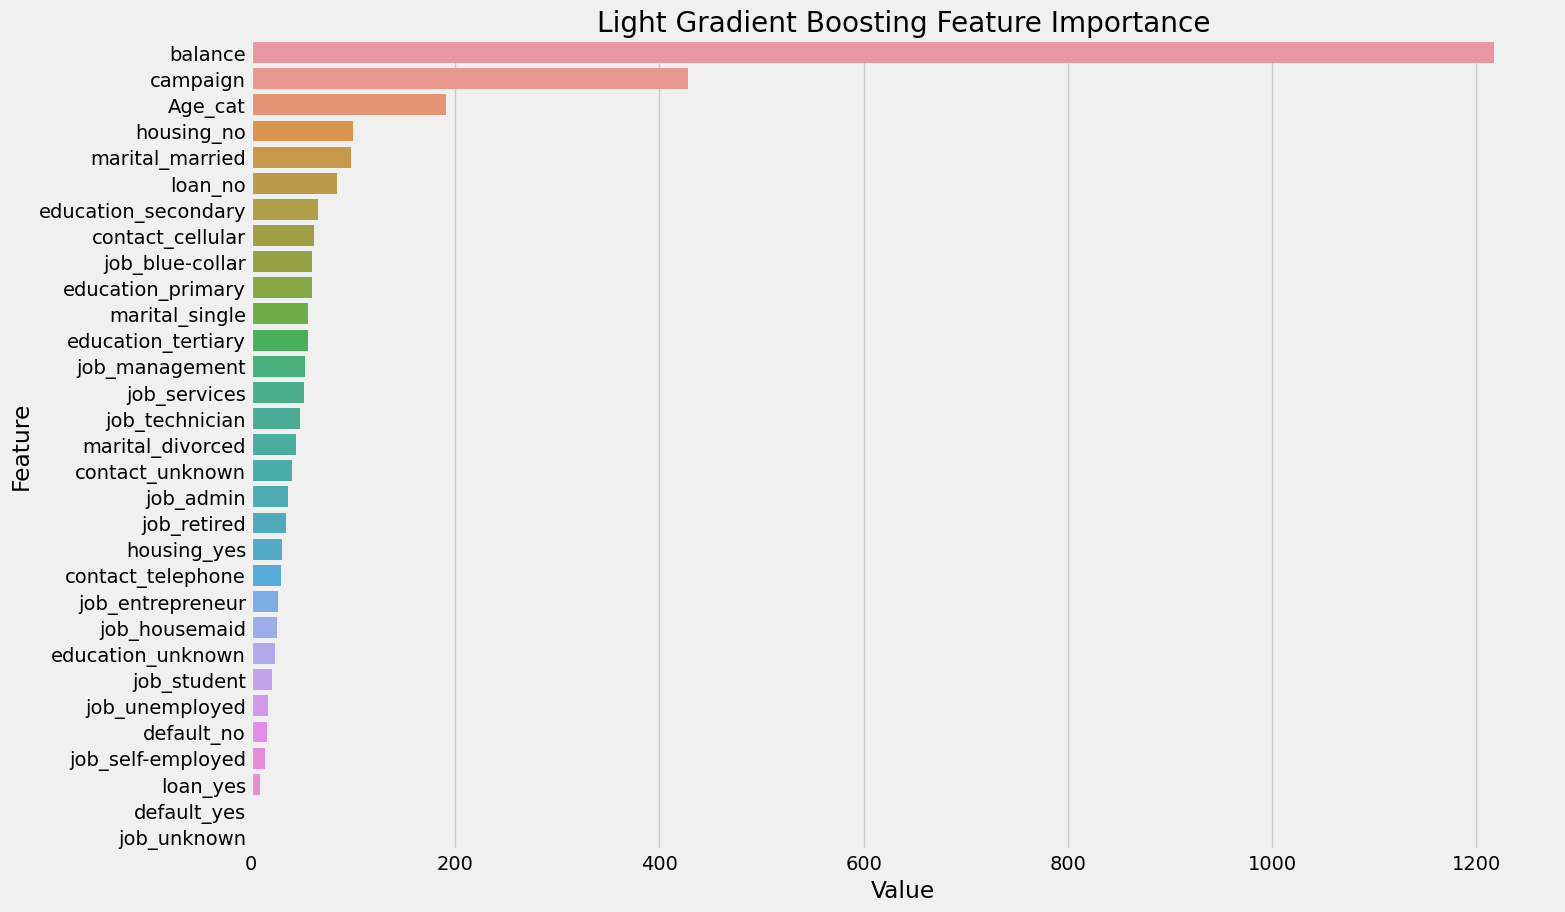

In [55]:
plt.figure(figsize=(15, 10))
sns.barplot(x="Value", y="Feature", data=lgb_feature_imp.sort_values(by="Value", ascending=False))
plt.title('Light Gradient Boosting Feature Importance')
plt.show()

## Light Gradient Boosting Confusion Matrix

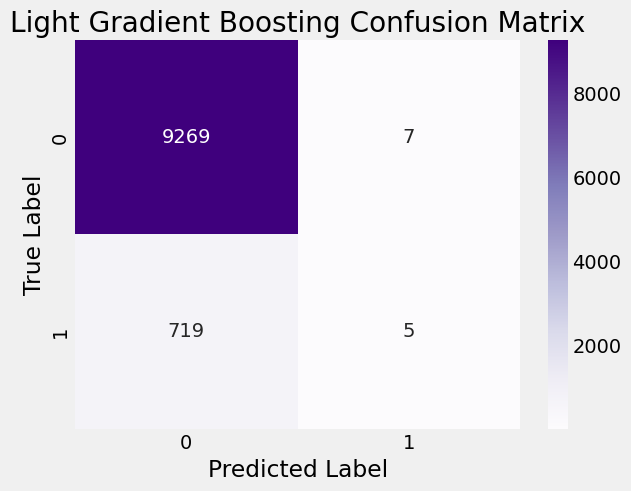

In [56]:
confusion_matrix(y_test, lgb.predict(X_test))
sns.heatmap(confusion_matrix(y_test, lgb.predict(X_test)), annot=True, fmt='d', cmap='Purples')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Light Gradient Boosting Confusion Matrix')
plt.show()


## Lift Analysis for Light Gradient Boosting

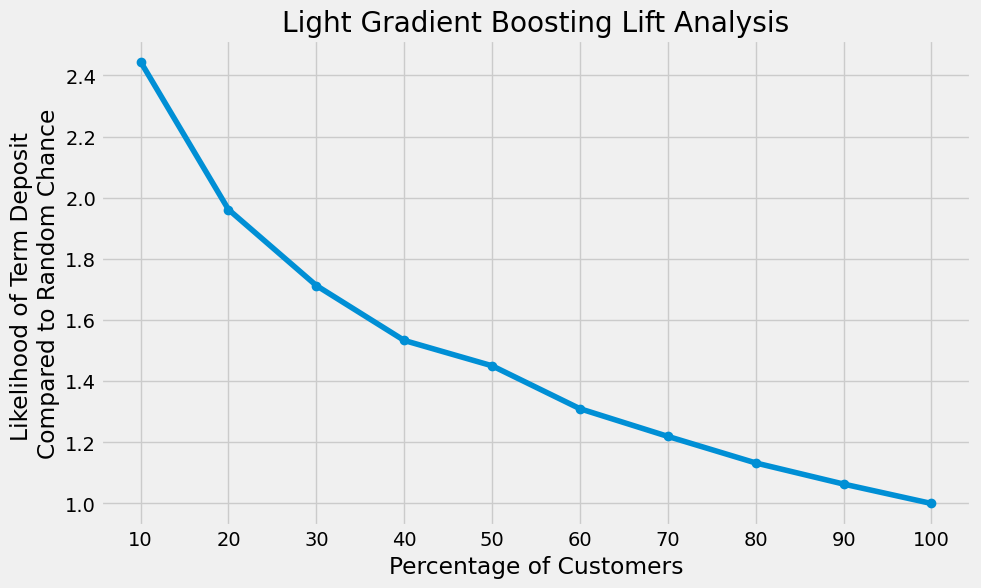

In [57]:
draw_lift_curve(y_test, lgb.predict_proba(X_test)[:,1], model="Light Gradient Boosting")


# Conclusion
Of the three models used in this project, the random forest model would be best suited for targeting customers who could be interested in opening a term deposit. Although the extreme gradient boosting (xgb) and light gradient boosting (lgb) models had higher maximum lift values than the random forest model, they were not able to correctly identify potential term deposit openers as the random forest did.

Also, in terms of model interpretability, the random forest model ranked 'balance' as its highest predictor in determining whether a customer would open a term deposit. This seems logical considering a customer who opens a term deposit could potentially use their existing balance in the term deposit.

Although the lgb model had the highest accuracy and maximum lift out of the three models, it ranked customers with unknown contact information as its highest predictor. This would not be helpful as the call centers would not have a legitmate of contacting these potential customers.